In this notebook the eQTLs and pQTLs indentified with statistical package MatrixEQTL are analysed with respect to yeast interactome (various kinds of genetic and physical interactions, with particular emphasis on protein-protein interactions).

In [15]:
# TODO: отрефакторить код (изменить названия, разбить на модули, разнести по отдельным файлам)
# TODO: найти новые pQTLs 
#       1. собрать подвыборку пар 
#       2. запустить анализ в R
#       3. доказать, что полученный результат не хуже (пока что почему-то не получается)
# TODO: привести данные в порядок!!!
#       1. убрать "загадочные гены" и повторы
#       2. всё перевести в одну номенклатуру и сохранить в ней
#       3. написать хотя бы краткое описание к файлам

%matplotlib inline

# utilities
from functools import partial
import time
import os

# data analysis tools
import random
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

# network analysis tools
import igraph as ig

# multiprocessing tools
import multiprocessing as mp


# visualization tools
import matplotlib.pyplot as plt
from matplotlib import cm

%autosave 15


Autosaving every 15 seconds


In [82]:
random.seed(int(time.time()))
# 112 segregants genotyped by inherited marker variants
''' TODO: find out why markers are duplicated '''
full_genotypes_df = pd.read_table("./data/genotypes_full.csv")

''' Where possible, gene names were converted from systematic to standard notation '''

# mRNA expression and genotypes of strains the data is available for
eQTLs_expression_df = pd.read_table("./data/eQTLs/averaged_expression.csv")
eQTLs_genotypes_df = pd.read_table("./data/eQTLs/genotypes_in_std.csv")
# Protein expression and genotypes of strains the data is available for 
pQTLs_expression_df = pd.read_table("./data/pQTLs/averaged_expression.csv")
pQTLs_genotypes_df = pd.read_table("./data/pQTLs/genotypes_in_std.csv")

# Estimated QTLs
eQTLs_df = pd.read_table("./data/eQTLs/results_nodup.csv")
pQTLs_df = pd.read_table("./data/pQTLs/results_nodup.csv")
# Physical and genetic interactions taken from BioGrid project
full_interactome_df = pd.read_table("./data/yeast_interactome.csv")
# full_interactome_df = full_interactome_df[full_interactome_df['Publication year'] <= 2011]
genetic_interaction_categories = [
    'additive genetic interaction defined by inequality',
    'suppressive genetic interaction defined by inequality',
    'synthetic genetic interaction defined by inequality'
]
physical_interaction_categories = [
    'association',
    'colocalization',   
    'direct interaction',
    'physical association'
]
interaction_categories = genetic_interaction_categories + physical_interaction_categories
interactome_df = full_interactome_df.copy()
interactome_df.set_index('Interaction Type', inplace=True)
genetic_interactions_df = interactome_df[
    interactome_df.index.isin(genetic_interaction_categories)
]
physical_interactions_df = interactome_df[
    interactome_df.index.isin(physical_interaction_categories)
]
# Genetic nomenclature and mappings between different naming conventions
gene_nomenclature_df = pd.read_table("./data/yeast_gene_nomenclature_mapping.csv")
gene_nomenclature_df.drop_duplicates("Systematic name", inplace=True)
std_to_sys = dict(zip(
    gene_nomenclature_df["Standard name"].values, 
    gene_nomenclature_df["Systematic name"].values
))
sys_to_std = {v: k for k, v in std_to_sys.items()}

In [18]:
# # Попытка привести все гены к единообразной кодировке
# 
# def try_rename(gene_name):
#     gene_name = gene_name.split('_')[0]
#     try:
#         return sys_to_std[gene_name]
#     except:
#         return gene_name
#         
# pQTL_df['SNP'] = pQTL_df['SNP'].apply(lambda s: try_rename(s))
# eQTL_df['SNP'] = eQTL_df['SNP'].apply(lambda s: try_rename(s))
# 
# full_genotypes_df["RQTL_name"] = full_genotypes_df["RQTL_name"].apply(lambda s: try_rename(s))
# full_genotypes_df.drop_duplicates("RQTL_name", inplace=True)
# pd.DataFrame.to_csv(full_genotypes_df, "./data/genotypes_in_std.csv", sep='\t', index=False, na_rep='NA')
# 
# eQTLs_genotypes_df["RQTL_name"] = eQTLs_genotypes_df["RQTL_name"].apply(lambda s: try_rename(s))
# eQTLs_genotypes_df.drop_duplicates("RQTL_name", inplace=True)
# pd.DataFrame.to_csv(eQTLs_genotypes_df, "./data/eQTLs/genotypes_in_std.csv", sep='\t', index=False, na_rep='NA')
# 
# pQTLs_genotypes_df["RQTL_name"] = pQTLs_genotypes_df["RQTL_name"].apply(lambda s: try_rename(s))
# pQTLs_genotypes_df.drop_duplicates("RQTL_name", inplace=True)
# pd.DataFrame.to_csv(pQTLs_genotypes_df, "./data/pQTLs/genotypes_in_std.csv", sep='\t', index=False, na_rep='NA')


In [81]:
# eQTL_df = pd.read_table("./data/eQTLs/results_nodup.csv")

# pQTL_df = pd.read_table("./data/pQTLs/results_nodup.csv")
# pQTL_df["gene"] = pQTL_df["gene"].apply(lambda s: s.split('/')[0].split(' ')[1])
# pd.DataFrame.to_csv(pQTL_df, "./data/pQTLs/results_nodup.csv", sep='\t', index=False, na_rep='NA')
# pQTLs_expression_df["protein.group"] = pQTLs_expression_df["protein.group"].apply(lambda s: s.split('/')[0].split(' ')[1])
# pd.DataFrame.to_csv(pQTLs_expression_df, "./data/pQTLs/averaged_expression.csv", sep='\t', index=False, na_rep='NA')

In [21]:
# Given a list of gene-gene interactions of some kind (pairs of genes treated as edges),
# construct a graph and, if specified, randomize it, preserving some invariant
def assemble_graph_of_interactions(edges, directed = False, randomize=False):
    # Зачем здесь граф? Без него должно быть можно обойтись.
    interaction_graph = ig.Graph(directed=directed)
    # For some weird reason, igraph can add multiple copies of the same
    # vertex without even signalling about it, therefore the duplicates
    # require manual removal from the dataset 
    vertices = set()
    for source, target in edges:
        vertices |= {source, target}
    vertex_names = list(vertices)
    interaction_graph.add_vertices(vertex_names)
    interaction_graph.add_edges(edges)
    ''' TODO:   There must be hundreds to thousands of 
                randomization iterations over which the
                results will be averaged and used,
                this must be implemented efficiently
    '''
    if randomize:
        if directed:
            interaction_graph = interaction_graph.Degree_Sequence(
                interaction_graph.outdegree(),
                interaction_graph.indegree(),
                method='vl'
            )
        else:
            interaction_graph = interaction_graph.Degree_Sequence(
                interaction_graph.degree(),
                method='vl'
            )
    # Due to domain-related specifics,
    # directed graphs produced by this function
    # will represent marker-gene interactions
    # and must be bipartite therefore
    if directed:
        interaction_graph.vs["type"] = \
            [False if deg > 0 else True for deg in interaction_graph.outdegree()] 
    interaction_graph.vs["name"] = vertex_names
    return interaction_graph
    
''' TODO:   Стоит попробовать более совершенные метрики
            подобия, а также добиться лучшей скорости работы 
'''
# Given a pair of graphs, representing gene-gene interactions
# and estimated QTL-linkages, calculate for each pair of interacting genes
# a Jaccard similarity coefficient, and then average it over all edges
def mean_linkage_similarity(interaction_graph, QTL_graph):
    linked_genes = set([vertex["name"] for vertex in QTL_graph.vs])
    interacting_genes = [vertex["name"] for vertex in interaction_graph.vs]

    mean_coeff = 0.
    # Перебрать все рёбра и сопоставить каждой вершине 
    # пару множеств: eQTLs и pQTLs, которые с ней линкуются,
    # а затем рассмотреть меру пересечения их объединения с мерой пересечения
    if interaction_graph.ecount():
        for edge in interaction_graph.es:
            s_id, t_id = edge.source, edge.target
            s_name = interacting_genes[s_id]
            t_name = interacting_genes[t_id]
            if s_name in linked_genes and t_name in linked_genes:
                s_neigh = set(QTL_graph.neighbors(s_name, mode="IN"))
                t_neigh = set(QTL_graph.neighbors(t_name, mode="IN"))
                mean_coeff += len(s_neigh & t_neigh) / len(s_neigh | t_neigh)
        mean_coeff /= interaction_graph.ecount()
    return mean_coeff

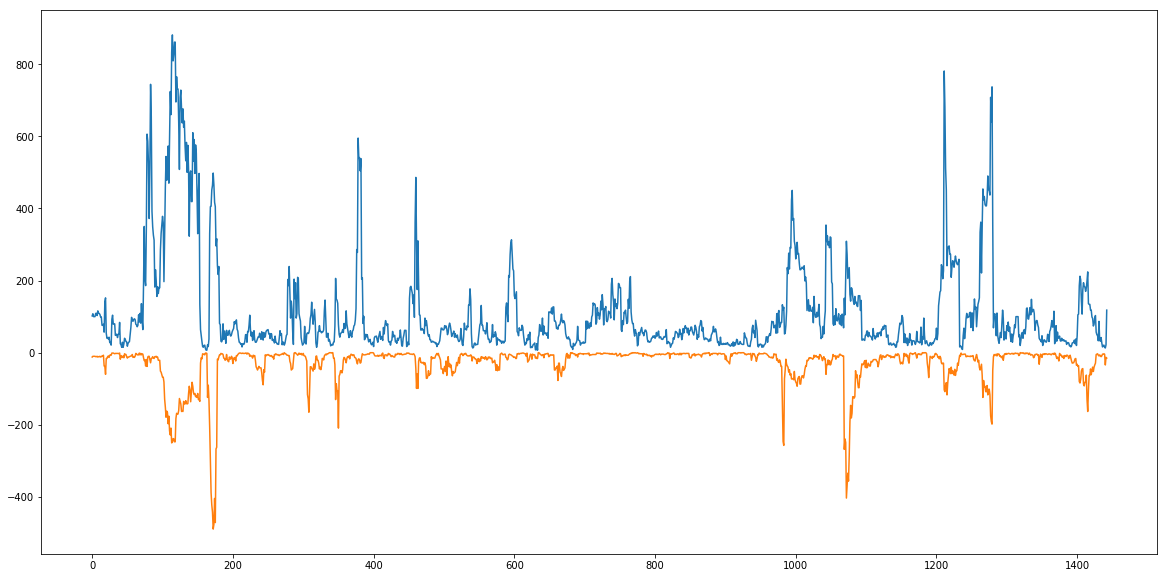

In [22]:
# Given a dataframe of estimated QTL linkages and 
# full strain genotype lookup table, plot the number
# of linkages against marker location in genome
def map_linkages_to_genome_location(QTL_df, full_genotypes_df):
    QTL_graph = assemble_graph_of_interactions (
        edges=QTL_df[["SNP", "gene"]].values,
        directed=True
    )
    # Select only the marker vertices
    left_part = QTL_graph.vs.select(type=False)
    # And map them to their absolute genome location 
    marker_to_rownum = \
    dict(
        zip(
            full_genotypes_df.iloc[:, 0],
            np.arange(full_genotypes_df.shape[0])
        )
    )
    # In order to combine plots for different QTLs
    # it's wise to plot them against the total set of markers,
    # disregarding whether linkages for the given marker
    # are calculated or not
    QTL_marker_to_linkages = \
    dict(
        zip(
            full_genotypes_df.iloc[:, 0],
            np.zeros(full_genotypes_df.shape[0])
        )           
    )
    # Add the available linkage data 
    QTL_marker_to_linkages.update(dict(zip(left_part["name"], left_part.outdegree())))
    # Sort the dictionary accordingly to the marker position on the chromosome
    # and unzip it to extract the ordered linkage list
    
    QTL_x, QTL_y = \
    map(list, 
        zip(
            *sorted(QTL_marker_to_linkages.items(), 
            key=lambda p: marker_to_rownum[p[0]])
        )
    )
    return QTL_x, QTL_y 
    
    
_, eQTL_y = map_linkages_to_genome_location(eQTL_df, full_genotypes_df)
_, pQTL_y = map_linkages_to_genome_location(pQTL_df, full_genotypes_df)

# ''' TODO:   Make the axes prettier '''
plt.figure(figsize=(20, 10))
plt.plot(eQTL_y)
plt.plot([-y for y in pQTL_y])
plt.savefig("./img/linkages/eQTLs_pQTLs_combined.png")

In [24]:
''' TODO:   Parallelize threshold processing 
            and run on cluster to achieve sufficient
            statistical power of at least 1000 thresholds
'''

# For q-value threshold in range [1e-8; 1e-3] 
# rebuild graph of interactions and calculate  
# mean value of Jaccard coefficient among graph vertices.

def analyze_interactions(QTL_df, Q_RANGE, REWIRE_FLAG=False):
    t0 = time.time()
    avg_similarity_by_category = {}
    ''' TODO: how to add more subcategories in a uniform way? '''
    for name in ['genetic', 'physical'] + interaction_categories:
        avg_similarity_by_category[name] = []
    interaction_graphs_dict = {}
    for category_name in interaction_categories:
        interacting_genes_df = interactome_df[interactome_df.index == category_name]
        interaction_graphs_dict[category_name] = assemble_graph_of_interactions(
            interacting_genes_df[["Interactor A", "Interactor B"]].values,
            randomize=REWIRE_FLAG
        )
    ''' TODO: Remove code duplication '''
    genetic_interactions_graph = assemble_graph_of_interactions(
        edges=genetic_interactions_df[["Interactor A", "Interactor B"]].values,
        randomize=REWIRE_FLAG
    )
    physical_interactions_graph = assemble_graph_of_interactions(
        edges=physical_interactions_df[["Interactor A", "Interactor B"]].values,
        randomize=REWIRE_FLAG
    )

    for Q_THRESHOLD in Q_RANGE[::-1]:
        # Accordingly to qvalue package in R, all estimated linkages
        # are significant, thereby p- and q-values are interchangeable.
        QTL_df = QTL_df[QTL_df['p.value'] <= Q_THRESHOLD]
        QTL_graph = assemble_graph_of_interactions (
            edges=QTL_df[["SNP", "gene"]].values,
            directed=True
        )
        avg_similarity_by_category['genetic'].append(
            mean_linkage_similarity(genetic_interactions_graph, QTL_graph)
        )
        avg_similarity_by_category['physical'].append(
            mean_linkage_similarity(physical_interactions_graph, QTL_graph)
        )
        for category_name, interaction_graph in interaction_graphs_dict.items():
            avg_similarity_by_category[category_name].append(
                mean_linkage_similarity(interaction_graph, QTL_graph)
            )
                
    print(time.time() - t0)
    return avg_similarity_by_category


In [25]:
def plot_similarity_comparison(avg_sim_by_category, avg_sim_by_category_randomized, type_of_QTLs, Q_RANGE):
   for name in avg_sim_by_category.keys():
        plt.figure(figsize=(20, 10))
        plt.xscale('log')
        plt.plot(Q_RANGE, avg_sim_by_category[name][::-1], label="original")
        plt.plot(Q_RANGE, avg_sim_by_category_randomized[name][::-1], label="randomized")
        plt.title('{} average linkage similarity'.format(type_of_QTLs))
        plt.xlabel(name)
        plt.legend()
        plt.savefig("./img/interactions/" + type_of_QTLs + '_' + name + ".png")
        plt.close()

In [ ]:
Q_RANGE = np.linspace(1e-8, 1e-3, 20)

# Is it possible to remove ugly code duplication?
avg_eQTLs_similarity = analyze_interactions(QTL_df=eQTL_df, Q_RANGE=Q_RANGE)
avg_eQTLs_similarity_for_randomized_interactions = analyze_interactions(QTL_df=eQTL_df, Q_RANGE=Q_RANGE, REWIRE_FLAG=True)
avg_pQTLs_similarity = analyze_interactions(QTL_df=pQTL_df, Q_RANGE=Q_RANGE)
avg_pQTLs_similarity_for_randomized_interactions = analyze_interactions(QTL_df=pQTL_df, Q_RANGE=Q_RANGE, REWIRE_FLAG=True)


In [47]:
plot_similarity_comparison(avg_eQTLs_similarity, avg_eQTLs_similarity_for_randomized_interactions, 'eQTLs', Q_RANGE)
plot_similarity_comparison(avg_pQTLs_similarity, avg_pQTLs_similarity_for_randomized_interactions, 'pQTLs', Q_RANGE)

NameError: name 'avg_eQTLs_similarity' is not defined

504


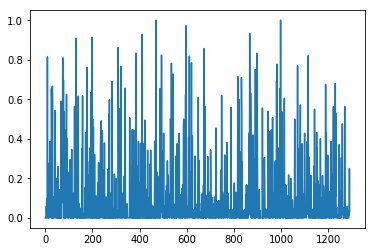

In [57]:
# Взять какой-то ген, рассмотреть его eQTLs и его соседей в графе физических взаимодействий,
# записать их в одно множество и выбрать p-значения всех пар данного гена с каким-то из них.
# Показать, что существенная часть выбранных генов будет pQTLs.
# pQTLs всё-таки придётся пересчитывать заново, потому что в pQTLs.csv
# уже проведена фильтрация по FDR, и никакого нового результата из этого
# датасета извлечь уже не выйдет.


def get_linked_genes(gene_name, QTL_df):
    return set(QTL_df[QTL_df["gene"] == gene_name]["SNP"].values)


def get_interacting_genes(gene_name, interaction_df):
    return set((interaction_df[interaction_df["Interactor A"] == gene_name]["Interactor B"].values)) \
           | set((interaction_df[interaction_df["Interactor B"] == gene_name]["Interactor A"].values)) 


similarity_hist = [] 
for gene_name in set(pQTL_df["gene"].values):
    linked = get_linked_genes(gene_name, eQTL_df)
    interacting = get_interacting_genes(gene_name, physical_interactions_df) \
                    | get_interacting_genes(gene_name, genetic_interactions_df)
    # interacting = set()
    pQTLs = get_linked_genes(gene_name, pQTL_df)
    similarity_hist.append(float(len((interacting | linked) & pQTLs)) / len(pQTLs))

plt.plot(similarity_hist)

In [63]:
sample_pairs = []  
for gene_name in pQTLs_expression_df["protein.group"].values:
    linked = set() #get_linked_genes(gene_name, eQTL_df)
    interacting = get_interacting_genes(gene_name, physical_interactions_df) \
                  | get_interacting_genes(gene_name, genetic_interactions_df) 
    sample_pairs += [(marker, gene_name) for marker in linked | interacting]
# print(time.time() - t0)sample_pairs

p_values = []
for sp in sample_pairs:
    marker, gene = sp
    genotype_row = pQTLs_genotypes_df[pQTLs_genotypes_df["RQTL_name"] == marker]
    if genotype_row.shape[0] == 1:
        genotype_row = genotype_row.values[0][1:]
        expression_row = pQTLs_expression_df[pQTLs_expression_df["protein.group"] == gene]
        expression_row = expression_row.values[0][1:]
        from_BY = expression_row[genotype_row == 0]
        from_RM = expression_row[genotype_row == 2]
        _, p_value = stats.mannwhitneyu(x=from_BY, y=from_RM)
        p_values.append(p_value)

In [59]:
#len(p_values)
len(sample_pairs)

102523

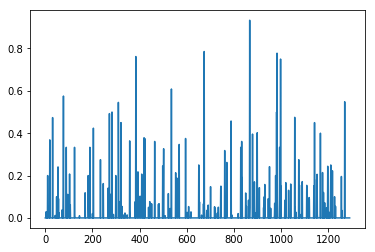

In [60]:
adjusted_results = multipletests(p_values, method="fdr_bh", alpha=0.05)
reject, q_values = adjusted_results[0], adjusted_results[1]
# reject = [p <= 0.05 for p in p_values]

pQTLs_found = {gene : [] for gene in pQTLs_expression_df["protein.group"]}
for i, _ in enumerate(reject):
    if not reject[i]: 
        pQTLs_found[sample_pairs[i][1]].append(sample_pairs[i][0])

similarity_hist = []
preserved = 0
total = 0
for gene_name in set(pQTL_df["gene"].values):
    try:
        pQTLs_old = get_linked_genes(gene_name, pQTL_df)
        pQTLs_new = set(pQTLs_found[gene_name])
        preserved += len(pQTLs_old & pQTLs_new)
        total += len(pQTLs_old)
        similarity_hist.append(len(pQTLs_old & pQTLs_new) / len(pQTLs_old))
    except:
        continue
# почему сохраняются только 646 pQTLs из многих тысяч?
plt.plot(similarity_hist)

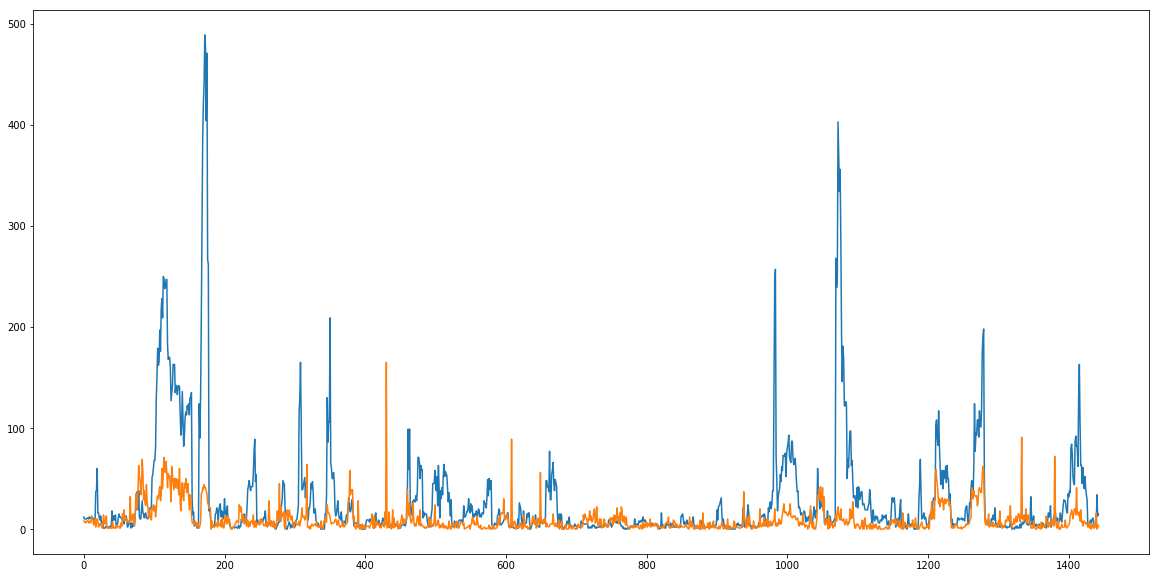

In [74]:
cool_list = []
for k, v in pQTLs_found.items():
    if len(v):
        for marker in v:
            if marker in full_genotypes_df["RQTL_name"].values:
                cool_list += [(marker, k)]
                
pQTLs_new_df = pd.DataFrame(cool_list, columns=["SNP", "gene"])
_, eQTL_y = map_linkages_to_genome_location(pQTL_df, full_genotypes_df)
_, pQTL_y = map_linkages_to_genome_location(pQTLs_new_df, full_genotypes_df)

''' TODO:   Make the axes prettier '''
plt.figure(figsize=(20, 10))
plt.plot(eQTL_y)
plt.plot([y for y in pQTL_y])
# plt.savefig("./img/linkages/eQTLs_pQTLs_combined.png")
    

In [50]:
print(pQTLs_new_df.shape)


(14502, 2)
